In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

df = pd.read_csv('./consumption_temp.csv')

df.head()

,time,location,consumption,temperature
0,2022-04-07 21:00:00,bergen,1.113325,-0.3
1,2022-04-07 21:00:00,oslo,4.092830,1.0
2,2022-04-07 21:00:00,stavanger,2.057858,1.3
3,2022-04-07 21:00:00,tromsø,1.246582,-3.9
4,2022-04-07 21:00:00,trondheim,1.970098,-2.8


In [56]:
# Print size of dataset
print(df.shape)

(49494, 4)


In [58]:
# Print the earliest and latest dates in the dataset
print(df['time'].min())
print(df['time'].max())

2022-04-07 21:00:00
2023-04-02 21:00:00


|Name|Type|Description|
|--|--|--|
|Id|number|Id of the column|
|Time|datetime|Date and time of the recorded consumption and temperature|
|Location|text|Location of where the recording is from|
|Consumption|float|Average hourly consumption measured in MW|
|Temperature|float|The weather forecast for the loaction at that hour|

In [10]:
print(df.location.unique())

['bergen' 'oslo' 'stavanger' 'tromsø' 'trondheim' 'helsingfors']


In [9]:
df.describe()

,consumption,temperature
count,49494.000000,49494.000000
mean,3.509242,6.554019
std,3.096356,7.630308
min,0.000000,-17.299999
25%,1.263256,1.000000
50%,2.376530,6.800000
75%,5.189000,12.100000
max,18.045011,30.500000


In [12]:
df_oslo = df[df.location == 'oslo']

df_oslo.head()

,time,location,consumption,temperature
1,2022-04-07 21:00:00,oslo,4.092830,1.0
6,2022-04-07 22:00:00,oslo,3.818095,0.4
11,2022-04-07 23:00:00,oslo,3.660981,0.3
16,2022-04-08 00:00:00,oslo,3.584066,0.2
21,2022-04-08 01:00:00,oslo,3.549536,0.4


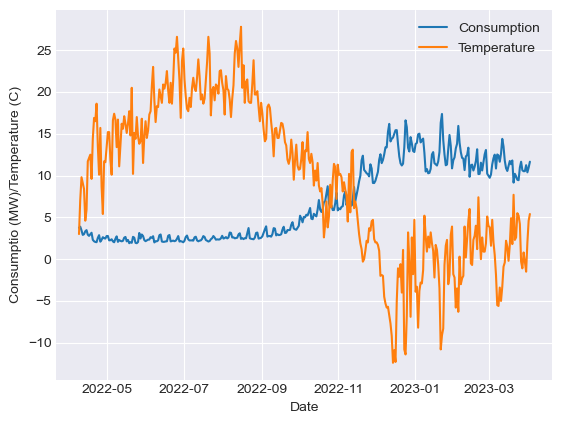

In [55]:
# Filter df_oslo to only include when time is 10:00
df_oslo['time'] = pd.to_datetime(df_oslo['time'])
filtered_df = df_oslo[df_oslo['time'].dt.hour == 10]

plt.plot(filtered_df['time'], filtered_df['consumption'])
plt.plot(filtered_df['time'], filtered_df['temperature'])
plt.xlabel('Date')
plt.ylabel('Consumptio (MW)/Temperature (C)')
plt.legend(['Consumption', 'Temperature'])
plt.show()

In [30]:
correlation = df['temperature'].corr(df['consumption'])
print(f"Correlation between temperature and consumptions: {correlation}")

Correlation between temperature and consumptions: -0.4364560903816127


In [27]:
df['time'] = pd.to_datetime(df['time'])

norway_map = folium.Map(location=[60.4720, 8.4689], zoom_start=5)

avg_consumption = df.groupby('location')['consumption'].mean().reset_index()

location_coordinates = {
    "bergen": (60.3913, 5.3221),
    "oslo": (59.9139, 10.7522),
    "stavanger": (58.9690, 5.7331),
    "tromsø": (69.6496, 18.9560),
    "trondheim": (63.4305, 10.3951),
    "helsingfors": (60.1699, 24.9384),
}

def scale_radius(consumption, max_radius=1000):
    return max_radius * np.log(1 + consumption)

for row in avg_consumption.itertuples():
    location = row.location
    avg_consumption = row.consumption
    lat, lon = location_coordinates[location]

    radius = scale_radius(avg_consumption)

    color = 'red' if avg_consumption > 3.5 else 'yellow' if avg_consumption > 2.5 else 'green'

    folium.Circle(
        location=[lat, lon],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"{location}: {avg_consumption}"
    ).add_to(norway_map)

norway_map

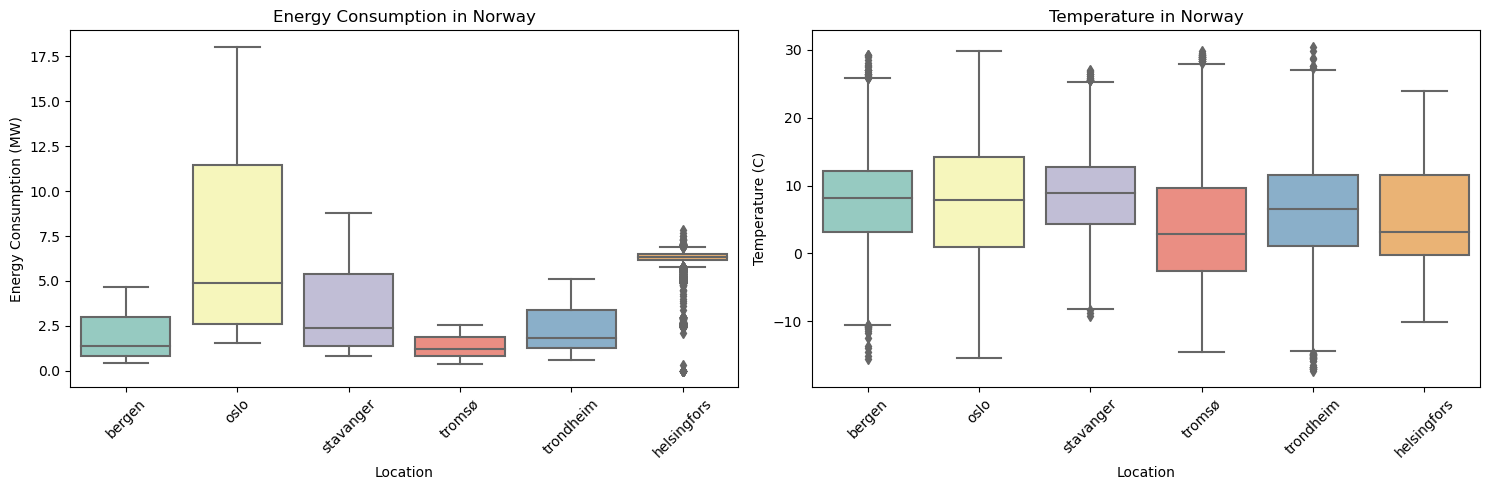

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df, x='location', y='consumption', palette='Set3', ax=axes[0])
axes[0].set_xlabel('Location')
axes[0].set_ylabel('Energy Consumption (MW)')
axes[0].set_title('Energy Consumption in Norway')

sns.boxplot(data=df, x='location', y='temperature', palette='Set3', ax=axes[1])
axes[1].set_xlabel('Location')
axes[1].set_ylabel('Temperature (C)')
axes[1].set_title('Temperature in Norway')

axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

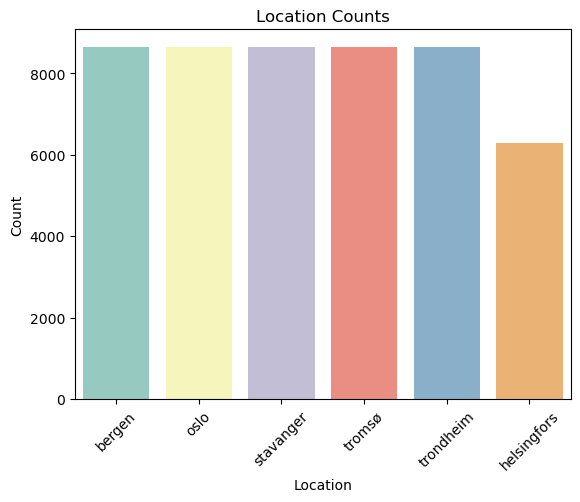

In [36]:
# Countplot of location counts
plt.figure
sns.countplot(data=df, x='location', palette='Set3')
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Location Counts')
plt.xticks(rotation=45)
plt.show()

In [49]:
oslo_count = df[df.location == 'oslo']['location'].count()
print(f"Number of entries for Oslo: {oslo_count}")
helsingfors_count = df[df.location == 'helsingfors']['location'].count()
print(f"Number of entries for Helsingfors: {helsingfors_count}")

# print diff
print(f"Difference: {oslo_count - helsingfors_count}")

Number of entries for Oslo: 8641
Number of entries for Helsingfors: 6289
Difference: 2352


In [40]:
helsinfors_data = df[df['location'] == 'helsingfors']['time']
bergen_data = df[df['location'] == 'bergen']['time']

missing_hours = bergen_data[~bergen_data.isin(helsinfors_data)]

if missing_hours.empty:
    print("No missing hours in Helsingfors compared to Bergen")
else:
    print(f"Missing hours in Helsingfors: \n{missing_hours}")

Missing hours in Helsingfors: 
0        2022-04-07 21:00:00
5        2022-04-07 22:00:00
10       2022-04-07 23:00:00
15       2022-04-08 00:00:00
20       2022-04-08 01:00:00
                ...         
11735    2022-07-14 16:00:00
11740    2022-07-14 17:00:00
11745    2022-07-14 18:00:00
11750    2022-07-14 19:00:00
11755    2022-07-14 20:00:00
Name: time, Length: 2352, dtype: object
